<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Time_and_seasons_cycles_as_tensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

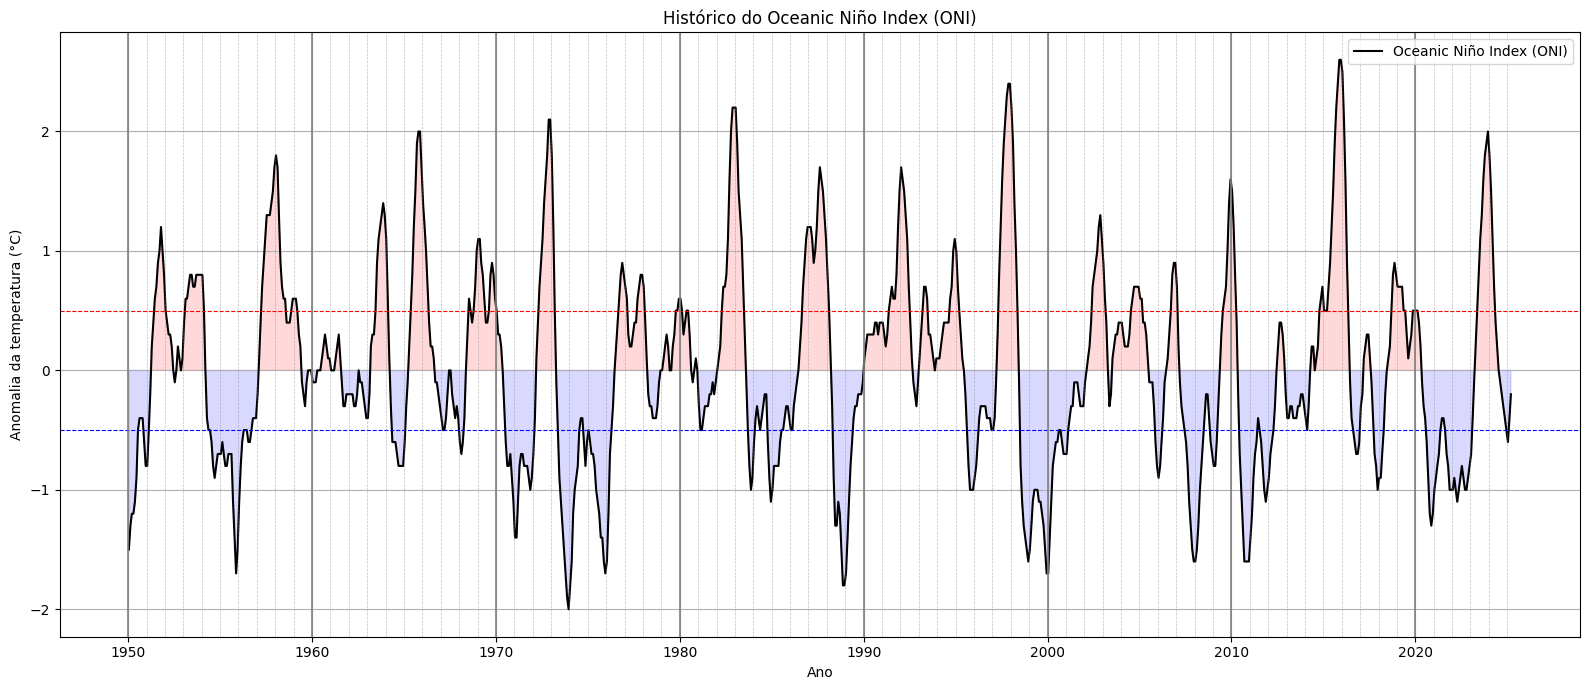

In [38]:
import datetime
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

class ONIIndex:
    def __init__(self, show_plot=True):
        # Lê e processa os dados ONI
        url = 'https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php'
        tables = pd.read_html(url, header=0)
        oni = tables[-3]
        oni = oni.rename(columns={oni.columns[0]: "Year"})
        oni = oni[oni["Year"].astype(str).str.isnumeric()]
        oni["Year"] = oni["Year"].astype(int)
        oni = oni.melt(id_vars=["Year"], var_name="Season", value_name="ONI")
        oni["ONI"] = pd.to_numeric(oni["ONI"], errors='coerce')
        oni = oni.dropna(subset=["ONI"])

        month_map = {
            "DJF": 1, "JFM": 2, "FMA": 3, "MAM": 4,
            "AMJ": 5, "MJJ": 6, "JJA": 7, "JAS": 8,
            "ASO": 9, "SON": 10, "OND": 11, "NDJ": 12
        }
        oni["Month"] = oni["Season"].map(month_map)
        oni["Date"] = pd.to_datetime(dict(year=oni["Year"], month=oni["Month"], day=15))
        oni = oni.sort_values("Date")

        self.data = oni[["Date", "ONI"]].reset_index(drop=True)

        if show_plot:
            self.plot()

    def plot(self):
        plt.figure(figsize=(16, 7))
        plt.plot(self.data["Date"], self.data["ONI"], label="Oceanic Niño Index (ONI)", color="black")
        plt.fill_between(self.data["Date"], 0, self.data["ONI"],
                         where=(self.data["ONI"] >= 0), interpolate=True, color='red', alpha=0.15)
        plt.fill_between(self.data["Date"], 0, self.data["ONI"],
                         where=(self.data["ONI"] <= 0), interpolate=True, color='blue', alpha=0.15)
        plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8)
        plt.axhline(-0.5, color='blue', linestyle='--', linewidth=0.8)

        for ano in self.data["Date"].dt.year.unique():
            linha = pd.Timestamp(f'{ano}-01-01')
            if ano % 10 == 0:
                plt.axvline(x=linha, color='gray', linestyle='-', linewidth=1.2)
            else:
                plt.axvline(x=linha, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

        plt.title("Histórico do Oceanic Niño Index (ONI)")
        plt.xlabel("Ano")
        plt.ylabel("Anomalia da temperatura (°C)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_nearest_value(self, date):
        if isinstance(date, datetime.datetime):
            date = date.date()
        elif not isinstance(date, datetime.date):
            raise ValueError("A entrada deve ser datetime.date ou datetime.datetime")

        # Encontra o índice da data mais próxima
        idx = (self.data["Date"] - pd.Timestamp(date)).abs().idxmin()
        return self.data.iloc[idx]["ONI"]

oni = ONIIndex()  # Instancia e plota

def encode_datetime_features(date):
    """
    Recebe uma data e retorna um tensor PyTorch com:
    - seno da época do ano (base 18 de março)
    - cosseno da época do ano (base 18 de março)
    - tempo normalizado entre 24/02/2000 e 24/02/2050
    """
    if not isinstance(date, (datetime.date, datetime.datetime)):
        raise ValueError("A entrada deve ser datetime.date ou datetime.datetime")

    # Garantir datetime.date
    if isinstance(date, datetime.datetime):
        date = date.date()

    # --- Cálculo senoidal com base no dia ideal (18 de março de 2025)
    base_sazonal = datetime.date(2025, 3, 18)
    delta_days = (date - base_sazonal).days % 365.25
    angle = (delta_days / 365.25) * 2 * np.pi
    sin_time = np.sin(angle)
    cos_time = np.cos(angle)

    # --- Cálculo da normalização entre a primeira imagem do TERRA e 2050
    start_global = datetime.date(2000, 2, 24) # Início da coleta de dados do satélie TERRA (MODIS)
    end_global = datetime.date(2050, 2, 24)
    total_seconds = (end_global - start_global).total_seconds()
    elapsed_seconds = (date - start_global).total_seconds()
    normalized_time = elapsed_seconds / total_seconds

    # --- Criar tensor PyTorch com os quatro valores
    tensor = torch.tensor([normalized_time, sin_time, cos_time, oni.get_nearest_value(date)/2], dtype=torch.float32)
    return tensor


In [39]:
now = datetime.datetime.now()
features = encode_datetime_features(now)
print(features)  # Tensor com [tempo_normalizado, sen, cos, oni]


tensor([ 0.5051,  0.9396,  0.3424, -0.1000])


In [40]:
print(encode_datetime_features(datetime.date(2021, 6, 18)))

tensor([ 0.4263,  0.9999, -0.0118, -0.2000])


In [41]:
print(encode_datetime_features(datetime.date(2022, 1, 1)))

tensor([ 0.4371, -0.9666,  0.2562, -0.5000])


In [42]:
print(encode_datetime_features(datetime.date(2027, 1, 1)))

tensor([ 0.5370, -0.9677,  0.2521, -0.1000])


In [43]:
oni.data

,Date,ONI
0,1950-01-15,-1.5
1,1950-02-15,-1.3
2,1950-03-15,-1.2
3,1950-04-15,-1.2
4,1950-05-15,-1.1
...,...,...
898,2024-11-15,-0.4
899,2024-12-15,-0.5
900,2025-01-15,-0.6
901,2025-02-15,-0.4
